# Forecasting 


In this lesson, we will practice forecasting using the following methods:  

- Last observed value  
- Simple average  
- Moving average
- Previous cycle 
- Holt's linear trend  
- Holt's seasonal trend
 

______________________________


We will acquire and prepare store sales data stored in our Codeup MySQL server, then forecast future values using each modeling approach and evaluate competing model performance.

In [1]:
# for presentation purposes
import warnings
warnings.filterwarnings("ignore")

# wrangle
from env import user, password, host
import os

# transform
import numpy as np
import pandas as pd

# visualize 
import matplotlib.pyplot as plt
import seaborn as sns

# working with dates
from datetime import datetime

# modeling
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

## Wrangle


We will acquire the data from our MySQL server and run the following prepare steps:
- Convert the `sale_date` column to be a datetime type
- Set the `sale_date` column as our index
- Rename `sale_amount` to `quantity` for clarity
- Create a new field called `sales_total` that is the product of `quantity` and `item_price`

In [2]:
def get_db_url(database):
    '''
    Returns a formatted string using credentials stored in env.py that can be passed to a pd.read_sql() function
    '''
    return f'mysql+pymysql://{user}:{password}@{host}/{database}'
    
def get_store_data():
    '''
    Returns a dataframe of all store data in the tsa_item_demand database and saves a local copy as a csv file.
    '''
    query = '''
            SELECT *
            FROM items
            JOIN sales USING(item_id)
            JOIN stores USING(store_id)
            '''
    
    df = pd.read_sql(query, get_db_url('tsa_item_demand'))
    df.to_csv('tsa_store_data.csv', index=False)
    return df

def wrangle_store_data():
    '''
    Checks for a local cache of tsa_store_data.csv and if not present will run the get_store_data() function which acquires data from Codeup's mysql server
    '''
    filename = 'tsa_store_data.csv'
    if os.path.isfile(filename):
        df = pd.read_csv(filename)
    else:
        df = get_store_data()
    return df

def prep_store_data(df):
    '''
    Prepares raw store data for analysis and time series modeling.
    '''
    df.sale_date = pd.to_datetime(df.sale_date)
    df = df.set_index('sale_date').sort_index()
    df = df.rename(columns={'sale_amount': 'quantity'})
    df['sales_total'] = df.quantity * df.item_price
    return df

In [3]:
df = wrangle_store_data()
df = prep_store_data(df)
df.head()

,store_id,item_id,item_upc14,item_upc12,item_brand,item_name,item_price,sale_id,quantity,store_address,store_zipcode,store_city,store_state,sales_total
sale_date,,,,,,,,,,,,,,
2013-01-01,1,1,35200264013,35200264013,Riceland,Riceland American Jazmine Rice,0.84,1,13,12125 Alamo Ranch Pkwy,78253,San Antonio,TX,10.92
2013-01-01,3,17,88313590791,88313590791,Ducal,Ducal Refried Red Beans,1.16,295813,26,2118 Fredericksburg Rdj,78201,San Antonio,TX,30.16
2013-01-01,10,7,70177154004,70177154004,Twinings Of London,Twinings Of London Classics Lady Grey Tea - 20 Ct,9.64,125995,32,8503 NW Military Hwy,78231,San Antonio,TX,308.48
2013-01-01,3,18,21200725340,21200725340,Scotch,Scotch Removable Clear Mounting Squares - 35 Ct,4.39,314073,45,2118 Fredericksburg Rdj,78201,San Antonio,TX,197.55
2013-01-01,3,19,41520035646,41520035646,Careone,Careone Family Comb Set - 8 Ct,0.74,332333,34,2118 Fredericksburg Rdj,78201,San Antonio,TX,25.16


Let's take a look at some of the details of our data:

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-01-01 to 2017-12-31
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   store_id       913000 non-null  int64  
 1   item_id        913000 non-null  int64  
 2   item_upc14     913000 non-null  int64  
 3   item_upc12     913000 non-null  int64  
 4   item_brand     913000 non-null  object 
 5   item_name      913000 non-null  object 
 6   item_price     913000 non-null  float64
 7   sale_id        913000 non-null  int64  
 8   quantity       913000 non-null  int64  
 9   store_address  913000 non-null  object 
 10  store_zipcode  913000 non-null  int64  
 11  store_city     913000 non-null  object 
 12  store_state    913000 non-null  object 
 13  sales_total    913000 non-null  float64
dtypes: float64(2), int64(7), object(5)
memory usage: 104.5+ MB


In [5]:
df.describe()

,store_id,item_id,item_upc14,item_upc12,item_price,sale_id,quantity,store_zipcode,sales_total
count,913000.000000,913000.000000,9.130000e+05,9.130000e+05,913000.000000,913000.000000,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,2.384688e+11,2.384688e+11,5.160400,456500.500000,52.250287,78224.800000,280.898866
std,2.872283,14.430878,2.978005e+11,2.978005e+11,2.737764,263560.542223,28.801144,16.479087,227.686575
min,1.000000,1.000000,8.500005e+09,8.500005e+09,0.600000,1.000000,0.000000,78201.000000,0.000000
25%,3.000000,13.000000,3.367410e+10,3.367410e+10,2.970000,228250.750000,30.000000,78217.000000,98.010000
50%,5.500000,25.500000,7.103651e+10,7.103651e+10,5.195000,456500.500000,47.000000,78220.500000,233.280000
75%,8.000000,38.000000,6.030842e+11,6.030842e+11,7.520000,684750.250000,70.000000,78232.000000,402.780000
max,10.000000,50.000000,8.846237e+11,8.846237e+11,9.640000,913000.000000,231.000000,78253.000000,2104.410000


For the purposes of our modeling, we will only work with one variable at a time (univariate). To this end, we can resample our dataframe to a daily time period, aggregating only the `quantity` and `sales_total` fields:

In [7]:
df_resampled = df.resample('d')[['quantity','sales_total']].sum()
df_resampled.head()

,quantity,sales_total
sale_date,,
2013-01-01,13696,73844.01
2013-01-02,13678,73570.58
2013-01-03,14488,78169.48
2013-01-04,15677,84467.73
2013-01-05,16237,87621.85


## Split

We will use a percentage based approach to splitting our time series data.  
1. Identify the total length of the dataframe and multiply by our desired perentage to get the number of rows that equates to the first x% of the dataframe, which equates to the first x% of the time covered in the data.

In [8]:
df_resampled.shape

(1826, 2)

In [9]:
# set train size to be 50% of total 
train_size = int(round(df_resampled.shape[0] * 0.5))
train_size

913

In [10]:
# set validate size to be 30% of total 
validate_size = int(round(df_resampled.shape[0] * 0.3))
validate_size

548

In [11]:
# set test size to be number of rows remaining. 
test_size = int(round(df_resampled.shape[0] * 0.2))
test_size

365

In [12]:
len(df_resampled) == train_size + validate_size + test_size

True

In [13]:
# validate will go from 913 to 913+548
validate_end_index = train_size + validate_size
validate_end_index

1461

2. Slice our dataframe using the index positions we identified for each section in the previous step.

In [14]:
# train will go from 0 to 912
train = df_resampled[:train_size]

In [15]:
train.tail()

,quantity,sales_total
sale_date,,
2015-06-28,37410,201002.82
2015-06-29,25074,134932.08
2015-06-30,29345,158904.06
2015-07-01,30703,164573.20
2015-07-02,33134,178036.64


The last observation for train occurred on `2015-07-02`. We will want to make sure that the first observation for validate is the very next day.

In [16]:
# validate will go from 912 to 1458
validate = df_resampled[train_size:validate_end_index]

In [17]:
validate.head()

,quantity,sales_total
sale_date,,
2015-07-03,35498,190981.55
2015-07-04,37776,203696.39
2015-07-05,39740,214040.37
2015-07-06,26519,142584.15
2015-07-07,30916,167146.03


The first observation for validate is `2015-07-03`. This means there is no gap in dates between train and validate. Likewise, we will want to make sure that the last observation in validate is adjacent to the first observation in test.

In [18]:
validate.tail()

,quantity,sales_total
sale_date,,
2016-12-27,19341,103657.89
2016-12-28,19560,105313.94
2016-12-29,21111,113221.85
2016-12-30,22296,120033.64
2016-12-31,23792,128009.31


In [19]:
# test will include 1459 to the end
test = df_resampled[validate_end_index:]

In [20]:
test.head()

,quantity,sales_total
sale_date,,
2017-01-01,23709,127262.71
2017-01-02,15772,85329.98
2017-01-03,18650,100389.65
2017-01-04,18510,99454.59
2017-01-05,19895,107613.80


In [21]:
train.shape[0], validate.shape[0], test.shape[0]

(913, 548, 365)

**Verify Splits**

Does the length of each df equate to the length of the original df? 

In [22]:
# is len of train + validate + test == lenght of entire dataframe. 
len(train) + len(validate) + len(test) == len(df_resampled)

True

Does the first row of original df equate to the first row of train? 

In [23]:
print(df_resampled.head(1) == train.head(1))

            quantity  sales_total
sale_date                        
2013-01-01      True         True


Is the last row of test the same as the last row of our original dataframe? 

In [24]:
pd.concat([test.tail(1), df_resampled.tail(1)])

,quantity,sales_total
sale_date,,
2017-12-31,26420,140905.74
2017-12-31,26420,140905.74


## Visualizing Our Data

Let's plot our data first, viewing where the data is split into train and test. 

In [25]:
train.columns

Index(['quantity', 'sales_total'], dtype='object')

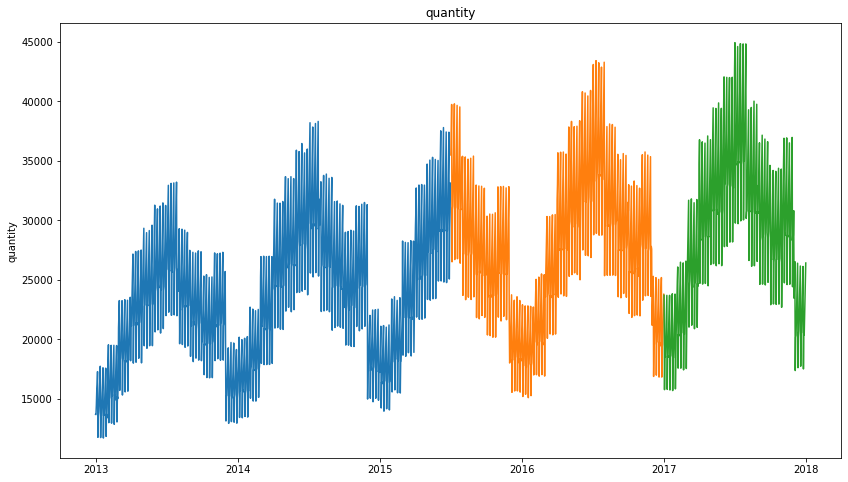

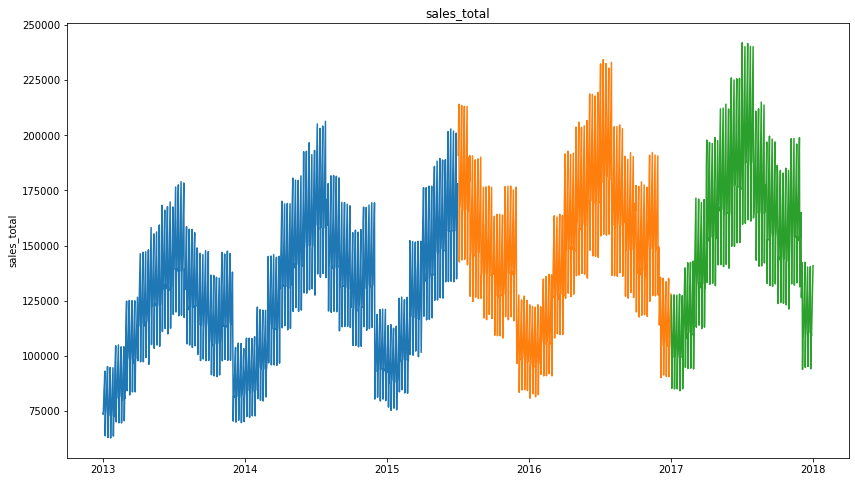

In [26]:
for col in train.columns:
    plt.figure(figsize=(14,8))
    plt.plot(train[col])
    plt.plot(validate[col])
    plt.plot(test[col])
    plt.ylabel(col)
    plt.title(col)
    plt.show()

## Creating Helpful Evaluation Functions

Before we try out different methods for forecasting sales and number of items sold, let's create a couple of functions that will be helpful in evaluating each of the modeling approaches we will use. 

`evaluate()` will compute the Mean Squared Error and the Root Mean Squared Error of our predictions compared to the actual values.

In [27]:
def evaluate(target_var):
    '''
    This function will take the actual values of the target_var from validate, 
    and the predicted values stored in yhat_df, 
    and compute the rmse, rounding to 0 decimal places. 
    it will return the rmse. 
    '''
    rmse = round(sqrt(mean_squared_error(validate[target_var], yhat_df[target_var])), 0)
    return rmse

`plot_and_eval()` will use the evaluate function and also plot train and test values with the predicted values in order to visualize our performance.

In [28]:
def plot_and_eval(target_var):
    '''
    This function takes in the target var name (string), and returns a plot
    of the values of train for that variable, validate, and the predicted values from yhat_df. 
    it will als lable the rmse. 
    '''
    plt.figure(figsize = (12,4))
    plt.plot(train[target_var], label='Train', linewidth=1)
    plt.plot(validate[target_var], label='Validate', linewidth=1)
    plt.plot(yhat_df[target_var])
    plt.title(target_var)
    rmse = evaluate(target_var)
    print(target_var, '-- RMSE: {:.0f}'.format(rmse))
    plt.show()

We are planning on evaluating a lot of models. Let's create an easy to read dataframe called `eval_df`. 

In [31]:
# create an empty dataframe
eval_df = pd.DataFrame(columns=['model_type', 'target_var', 'rmse'])
eval_df

,model_type,target_var,rmse


Rather than manually appending the results of each model, we can create a function that will do it for us. 

`append_eval_df(model_type)` will append evaluation metrics for each model into our `eval_df` data frame object. 

In [30]:
# function to store the rmse so that we can compare
def append_eval_df(model_type, target_var):
    '''
    this function takes in as arguments the type of model run, and the name of the target variable. 
    It returns the eval_df with the rmse appended to it for that model and target_var. 
    '''
    rmse = evaluate(target_var)
    d = {'model_type': [model_type], 'target_var': [target_var],
        'rmse': [rmse]}
    d = pd.DataFrame(d)
    return eval_df.append(d, ignore_index = True)

## Forecast 

Forecasting is another word for predicting time series data. As a reminder, we will work with the following approaches:

#### Baseline Models
1. Last Observed Value
2. Simple Average
3. Moving Average

#### Non-Baseline Models
4. Previous Cycle
5. Holt's Linear Trend
6. Holt's Seasonal Trend


## Last Observed Value

The simplest method for forecasting is to predict all future values to be the last observed value.  

### Make Predictions

What was the last observed value for `sales_total` in our training data?

In [32]:
train['sales_total'][-1:][0]

178036.64000000013

In [34]:
# take the last item of sales total and assign to variable
last_sales = train['sales_total'][-1:][0]

What was the last observed value for `quantity` in our training data?

In [35]:
# take the last item of quantity and assign to variable
last_quantity = train['quantity'][-1:][0]
last_quantity

33134

We can create a dataframe containing our predictions (which will all be the same value with this baseline approach):

In [36]:
yhat_df = pd.DataFrame(
    {'sales_total': [last_sales],
     'quantity': [last_quantity]},
    index=validate.index)

yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,178036.64,33134
2015-07-04,178036.64,33134
2015-07-05,178036.64,33134
2015-07-06,178036.64,33134
2015-07-07,178036.64,33134


In [37]:
yhat_df.describe()

,sales_total,quantity
count,5.480000e+02,548.0
mean,1.780366e+05,33134.0
std,4.369563e-10,0.0
min,1.780366e+05,33134.0
25%,1.780366e+05,33134.0
50%,1.780366e+05,33134.0
75%,1.780366e+05,33134.0
max,1.780366e+05,33134.0


The output of `.describe()` confims that every predicted value is the same.  

### Plot Actual vs. Predicted Values

Let's plot actual and predicted values using our `plot_and_eval()` function

quantity -- RMSE: 7973


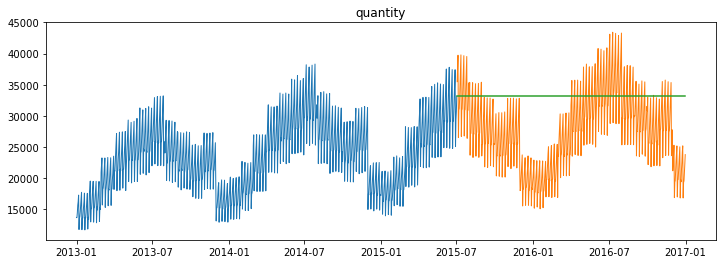

sales_total -- RMSE: 42805


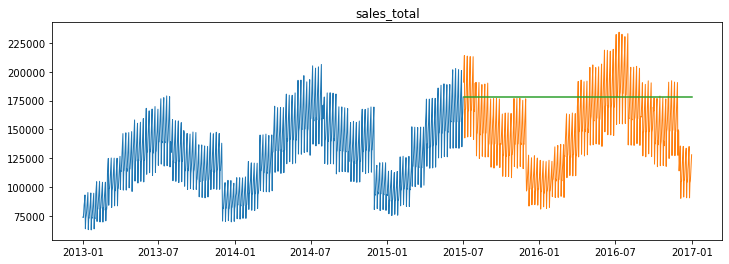

In [39]:
for col in train.columns:
    plot_and_eval(col)

**Evaluate** 

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`. We can use our `append_eval_df` function to accomplish this.

In [40]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'last_observed_value', 
                             target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0


## Simple Average

Take the simple average of historical values in train and use that value to predict future values.   

This is another good option for an initial baseline. Every predicted period (those in 'test') will be assigned the same value (the average of the entire training set).  

**Make Predictions**

In [41]:
# compute simple average of sales_total (from train data)
avg_sales = round(train['sales_total'].mean(), 2)
avg_sales

127573.19

In [42]:
# compute simple average of quantity (from train data)
avg_quantity = round(train['quantity'].mean(), 2)
avg_quantity

23728.25

Make a prediction for the value of `sales_total` and `quantity`, stored as the dataframe `yhat_df` for every day of the validate index. We can turn this into a function for ease of continued use.

In [44]:
def make__baseline_predictions(sales_predictions=None, quantity_predictions=None):
    yhat_df = pd.DataFrame({'sales_total': [sales_predictions],
                           'quantity': [quantity_predictions]},
                          index=validate.index)
    return yhat_df

In [45]:
yhat_df = make_baseline_predictions(avg_sales, avg_quantity)

In [46]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,127573.19,23728.25
2015-07-04,127573.19,23728.25
2015-07-05,127573.19,23728.25
2015-07-06,127573.19,23728.25
2015-07-07,127573.19,23728.25


In [47]:
yhat_df.describe()

,sales_total,quantity
count,5.480000e+02,548.00
mean,1.275732e+05,23728.25
std,9.467387e-10,0.00
min,1.275732e+05,23728.25
25%,1.275732e+05,23728.25
50%,1.275732e+05,23728.25
75%,1.275732e+05,23728.25
max,1.275732e+05,23728.25


### Plot Actual vs. Predicted Values

Similar to our handling of the previous baseline model, we can plot our `yhat_df` values against the actual values in validate. Our `plot_and_eval()` function accomplishes this.

quantity -- RMSE: 7360


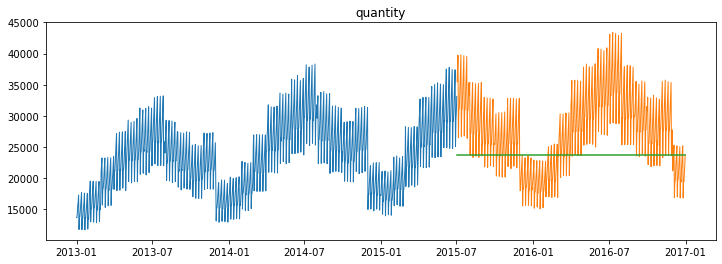

sales_total -- RMSE: 39568


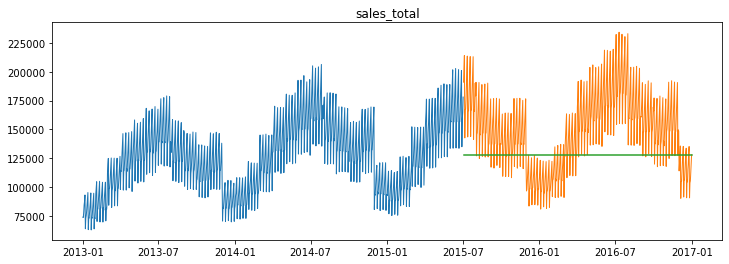

In [48]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [49]:
for col in train.columns:
    eval_df = append_eval_df(model_type='simple_average', 
                            target_var = col)
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0


## Moving Average

In this example, we will use a 30-day moving average to forecast. In other words, the average over the last 30-days will be used as the forecasted value. 

**Make Predictions**

There could be several ways to obtain the value of the last 30 periods in `train`. We will use the `.rolling()` method to accomplish this. 

In [52]:
period=30
train['sales_total'].rolling(period).mean()

sale_date
2013-01-01              NaN
2013-01-02              NaN
2013-01-03              NaN
2013-01-04              NaN
2013-01-05              NaN
                  ...      
2015-06-28    170365.098000
2015-06-29    168925.788333
2015-06-30    167925.392000
2015-07-01    168957.912000
2015-07-02    169649.376333
Freq: D, Name: sales_total, Length: 913, dtype: float64

`.rolling()` gives us an array of moving averages. We will only need the last one.

In [53]:
period=30
train['sales_total'].rolling(period).mean()[-1]

169649.37633333335

In [54]:
# Saving the last 30 day moving average for each column
rolling_sales = round(train['sales_total'].rolling(period).mean()[-1], 2)
rolling_quantity = round(train['quantity'].rolling(period).mean()[-1], 2)
print(rolling_sales, rolling_quantity)

169649.38 31561.9


We can use our `make_baseline_predictions()` function to create the newest version of the `yhat_df`:

In [55]:
yhat_df = make_predictions(rolling_sales, rolling_quantity)
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,169649.38,31561.9
2015-07-04,169649.38,31561.9
2015-07-05,169649.38,31561.9
2015-07-06,169649.38,31561.9
2015-07-07,169649.38,31561.9


### Plot Actual vs. Predicted Values

Now, let's plot and evaluate the performance of our time series model using **Moving Average**

quantity -- RMSE: 7048


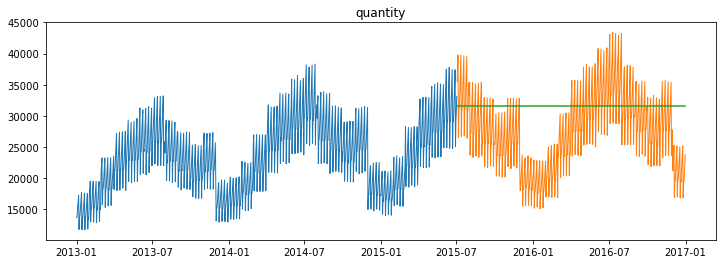

sales_total -- RMSE: 37882


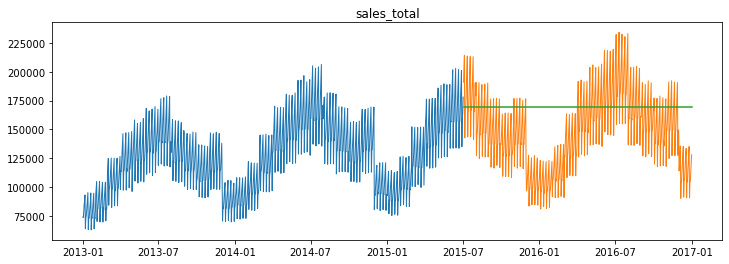

In [56]:
for col in train.columns:
    plot_and_eval(col)

### Evaluate

Evaluate using MSE and RMSE, and add evaluation metrics to `eval_df`

In [57]:
for col in train.columns:
    eval_df = append_eval_df(model_type = '30d_moving_avg', 
                            target_var = col)

eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0
4,30d_moving_avg,quantity,7048.0
5,30d_moving_avg,sales_total,37882.0


Let's try out several other values for our period:

In [58]:
periods = [4, 12, 26, 52, 104]

for p in periods: 
    rolling_sales = round(train['sales_total'].rolling(p).mean()[-1], 2)
    rolling_quantity = round(train['quantity'].rolling(p).mean()[-1], 2)
    yhat_df = make_predictions(rolling_sales, rolling_quantity)
    model_type = str(p) + '_day_moving_avg'
    for col in train.columns:
        eval_df = append_eval_df(model_type = model_type,
                                target_var = col)

In [59]:
eval_df

,model_type,target_var,rmse
0,last_observed_value,quantity,7973.0
1,last_observed_value,sales_total,42805.0
2,simple_average,quantity,7360.0
3,simple_average,sales_total,39568.0
4,30d_moving_avg,quantity,7048.0
5,30d_moving_avg,sales_total,37882.0
6,4_day_moving_avg,quantity,6258.0
7,4_day_moving_avg,sales_total,33696.0
8,12_day_moving_avg,quantity,6929.0
9,12_day_moving_avg,sales_total,37297.0


Which is best so far? 

In [62]:
best_quantity_rmse = eval_df[eval_df.target_var == 'quantity']['rmse'].min()

In [63]:
best_quantity_rmse

6130.0

In [64]:
eval_df[eval_df.rmse == best_quantity_rmse]

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,6130.0


In [65]:
best_sales_total_rmse = eval_df[eval_df.target_var == 'sales_total']['rmse'].min()

eval_df[eval_df.rmse == best_sales_total_rmse]

,model_type,target_var,rmse
15,104_day_moving_avg,sales_total,32959.0


As far as baselines are concerned, it looks like our 104 day moving average is a good starting point for comparisons.

# Non-Baseline Models

## Holt-Winters

Two of the models that we will evaluate are based on Holt-Winters, which models on three elements:
- A typical value (average)
- A slope (trend) over time
- And a cyclical repeating pattern (seasonality)

This means that its worth looking at a seasonal decomposition plot of our target, to inspect these components:

**Seasonal Decomposition**

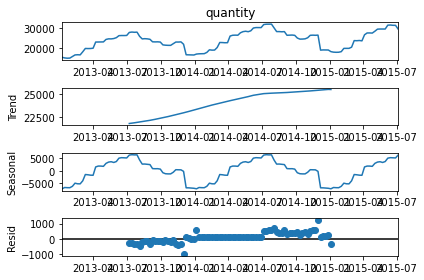

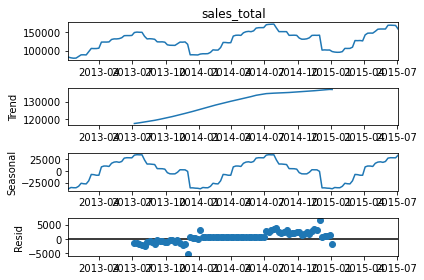

In [68]:
for col in train.columns:
    sm.tsa.seasonal_decompose(train[col].resample('W').mean()).plot()

It looks like there is both strong seasonality and a notable trend in both targets (`sales_total` and `quantity`). There are two Holt-Winters models that we will attempt
- Holt's Linear Model
- Holt's Seasonal Model

### Holt's Linear Model

Our approach will be similar to many other modeling processes we have performed:
1. Create the object (`Holt()`)
2. Fit the object (`.fit()`)
3. Make predictions (`.predict()`)

The first set of hyperparameters are set when we call `Holt()`: 

- **exponential** = True/False (exponential vs. linear growth, additive vs. multiplicative)
- **damped $\phi$** = True/False
    - with Holt, forecasts tend to increase or decrease indefinitely into the future.  To avoid absurd long term predictions, use the Damped method (True) which sets a damping parameter between 0< ϕ <1. 

A second set of hyperparameters are set when we call `.fit()`: 

- **smoothing_level ($\alpha$)**: value between (0,1)
    - Closer to 0, the level doesn't change with each new observation
    - Closer to 1, the level reacts strongly with each new observation
- **smoothing_slope ($\beta$)**: value between (0,1)
    - Closer to 0, trend is not changing over time
    - Closer to 1, trend is changing significantly over time
- **optimized**: use the auto-optimization that allow statsmodels to automatically find an optimized value for us. 

In [81]:
col = 'sales_total' 
# create our Holt Object
model = Holt(train[col], exponential=False, damped=True)

In [82]:
# fit the Holt object
model = model.fit(optimized=True)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [83]:
yhat_sales_total = model.predict(start = validate.index[0],
                              end = validate.index[-1])

In [74]:
validate.shape

(548, 2)

In [84]:
yhat_sales_total

2015-07-03    171134.717506
2015-07-04    171283.084125
2015-07-05    171429.967079
2015-07-06    171575.381203
2015-07-07    171719.341186
                  ...      
2016-12-27    185908.102338
2016-12-28    185908.735110
2016-12-29    185909.361553
2016-12-30    185909.981733
2016-12-31    185910.595710
Freq: D, Length: 548, dtype: float64

We've successfully created an array of predictions on the validate set for `sales_total`. Lets run a loop that will create a dataframe of predictions for every column in our training set:

In [85]:
# doing this in a loop for each column
for col in train.columns:
    model = Holt(train[col], exponential=False, damped=True)
    model = model.fit(optimized=True)
    yhat_values = model.predict(start = validate.index[0],
                              end = validate.index[-1])
    yhat_df[col] = round(yhat_values, 2)

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [92]:
yhat_df.head()

,sales_total,quantity
sale_date,,
2015-07-03,171134.72,31831.17
2015-07-04,171283.08,31858.88
2015-07-05,171429.97,31886.32
2015-07-06,171575.38,31913.48
2015-07-07,171719.34,31940.36


**Plot Actual vs. Predicted Values**

quantity -- RMSE: 8692


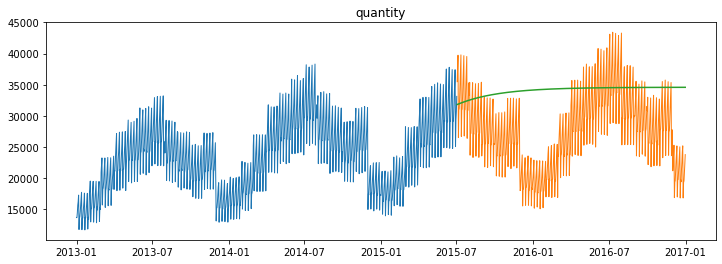

sales_total -- RMSE: 46703


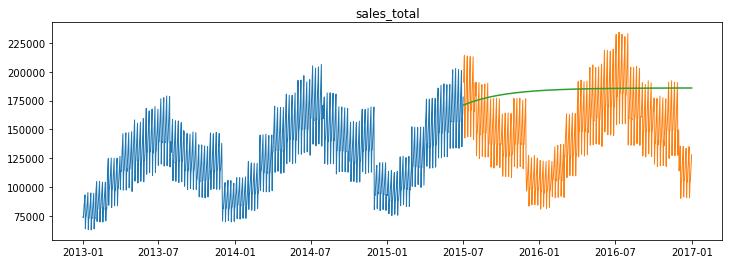

In [93]:
for col in train.columns:
    plot_and_eval(target_var = col)

Just from visual inspection, Holt's Linear Trend doesn't seem to be that much better than our other baselines. It fails to adequately predict the strong seasonality present in our data. This is not surprising. Holt's Linear Trend tends to work better with data with a strong trend but limited seasonality. 

**Evaluate**

In [94]:
for col in train.columns:
    eval_df = append_eval_df(model_type = 'holts_optimized', 
                            target_var = col)

In [95]:
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,6130.0
6,4_day_moving_avg,quantity,6258.0
12,52_day_moving_avg,quantity,6666.0
8,12_day_moving_avg,quantity,6929.0
10,26_day_moving_avg,quantity,6991.0
4,30d_moving_avg,quantity,7048.0
2,simple_average,quantity,7360.0
0,last_observed_value,quantity,7973.0
16,holts_optimized,quantity,8692.0
15,104_day_moving_avg,sales_total,32959.0


### Holt's Seasonal Trend

Similar to our most recent model, Holt's Seasonal Trend 

In [97]:
# Models for quantity
fit1 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add').fit()
fit2 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul').fit()
fit3 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
fit4 = ExponentialSmoothing(train.quantity, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

# Models for sales
fit5 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add').fit()
fit6 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul').fit()
fit7 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='add', damped=True).fit()
fit8 = ExponentialSmoothing(train.sales_total, seasonal_periods=365, trend='add', seasonal='mul', damped=True).fit()

/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/holtwinters/model.py:920: Convergen

In [98]:
fit1.params

{'smoothing_level': 0.040357142857142855,
 'smoothing_trend': 0.024214285714285716,
 'smoothing_seasonal': 0.582640306122449,
 'damping_trend': nan,
 'initial_level': 15492.666666666666,
 'initial_trend': 8.964075811596922,
 'initial_seasons': array([-1.79666667e+03, -1.81466667e+03, -1.00466667e+03,  1.84333333e+02,
         7.44333333e+02,  1.79833333e+03, -3.72366667e+03, -1.93266667e+03,
        -1.61466667e+03, -8.50666667e+02,  1.40333333e+02,  1.18633333e+03,
         2.24833333e+03, -3.74666667e+03, -1.86766667e+03, -1.90166667e+03,
        -9.05666667e+02,  2.33333333e+00,  8.01333333e+02,  2.11933333e+03,
        -3.78366667e+03, -1.76866667e+03, -1.87966667e+03, -1.02066667e+03,
         1.47333333e+02,  1.06833333e+03,  2.08633333e+03, -3.64466667e+03,
        -1.76866667e+03, -2.10166667e+03, -7.68666667e+02,  1.98033333e+03,
         2.83033333e+03,  4.05133333e+03, -2.49466667e+03, -5.36666667e+02,
        -3.68666667e+02,  6.19333333e+02,  1.95733333e+03,  2.93233333e+0

In [99]:
results_quantity=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results_quantity["Additive(fit1-Quantity)"] = [fit1.params[p] for p in params] + [fit1.sse]
results_quantity["Multiplicative(fit2-Quantity)"] = [fit2.params[p] for p in params] + [fit2.sse]
results_quantity["Additive_Dampened(fit3-Quantity)"]   = [fit3.params[p] for p in params] + [fit3.sse]
results_quantity["Multiplicative_Dampened(fit4-Quantity)"] = [fit4.params[p] for p in params] + [fit4.sse]

In [100]:
results_quantity

,Additive(fit1-Quantity),Multiplicative(fit2-Quantity),Additive_Dampened(fit3-Quantity),Multiplicative_Dampened(fit4-Quantity)
$\alpha$,4.035714e-02,4.035714e-02,4.035714e-02,4.035714e-02
$\beta$,2.421429e-02,4.035714e-02,3.228571e-02,1.000000e-04
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,5.826403e-01,6.169133e-01,5.826403e-01,6.511862e-01
$l_0$,1.549267e+04,1.549267e+04,1.549267e+04,1.549267e+04
$b_0$,8.964076e+00,8.964076e+00,8.964076e+00,8.964076e+00
SSE,8.819120e+09,9.989963e+09,8.801706e+09,9.823276e+09


In [101]:
# Which test performed the best?
results_quantity.T[results_quantity.T['SSE'] == results_quantity.T.SSE.min()].index[0]

'Additive_Dampened(fit3-Quantity)'

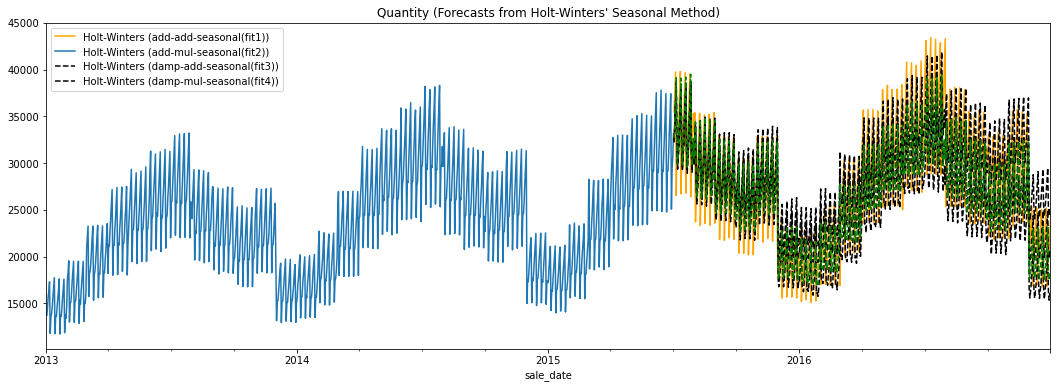

In [102]:
ax = validate.quantity.plot(figsize=(18,6), color='orange', title="Quantity (Forecasts from Holt-Winters' Seasonal Method)")
ax.set_ylabel("")
ax.set_xlabel("Year")
train.quantity.plot()
#fit1.fittedvalues.plot(ax=ax, style='--', color='blue')
#fit2.fittedvalues.plot(ax=ax, style='--', color='orange')

fit1.forecast(validate.shape[0]).rename('Holt-Winters (add-add-seasonal(fit1))').plot(ax=ax, style='--', color='black', legend=True)
fit2.forecast(validate.shape[0]).rename('Holt-Winters (add-mul-seasonal(fit2))').plot(ax=ax, style='--', color='black', legend=True)
fit3.forecast(validate.shape[0]).rename('Holt-Winters (damp-add-seasonal(fit3))').plot(ax=ax, style='--', color='black', legend=True)
fit4.forecast(validate.shape[0]).rename('Holt-Winters (damp-mul-seasonal(fit4))').plot(ax=ax, style='--', color='green', legend=True)

plt.show()

In [103]:
results_sales=pd.DataFrame(index=[r"$\alpha$",r"$\beta$",r"$\phi$",r"$\gamma$",r"$l_0$","$b_0$","SSE"])
params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'smoothing_seasonal', 'initial_level', 'initial_trend']
results_sales["Additive(fit5-Sales)"] = [fit5.params[p] for p in params] + [fit5.sse]
results_sales["Multiplicative(fit6-Sales)"] = [fit6.params[p] for p in params] + [fit6.sse]
results_sales["Additive_Dampened(fit7-Sales)"]   = [fit7.params[p] for p in params] + [fit7.sse]
results_sales["Multiplicative_Dampened(fit8-Sales)"] = [fit8.params[p] for p in params] + [fit8.sse]

In [104]:
results_sales

,Additive(fit5-Sales),Multiplicative(fit6-Sales),Additive_Dampened(fit7-Sales),Multiplicative_Dampened(fit8-Sales)
$\alpha$,4.035714e-02,4.035714e-02,4.035714e-02,4.035714e-02
$\beta$,3.228571e-02,4.035714e-02,3.228571e-02,1.000000e-04
$\phi$,NaN,NaN,9.900000e-01,9.900000e-01
$\gamma$,5.826403e-01,6.511862e-01,5.826403e-01,6.511862e-01
$l_0$,8.335370e+04,8.335370e+04,8.335370e+04,8.335370e+04
$b_0$,4.814335e+01,4.814238e+01,4.814335e+01,4.814335e+01
SSE,2.544809e+11,3.052110e+11,2.539738e+11,2.834488e+11


In [105]:
# Which test performed the best?
results_sales.T[results_sales.T['SSE'] == results_sales.T.SSE.min()].index[0]

'Additive_Dampened(fit7-Sales)'

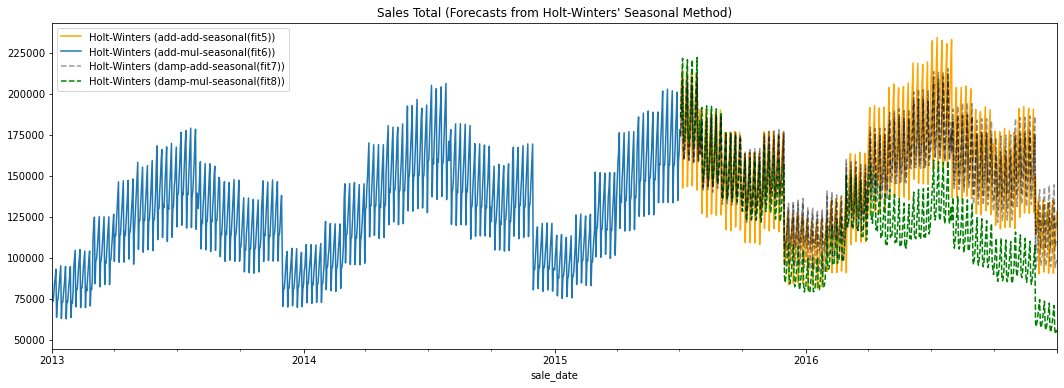

In [107]:
ax = validate.sales_total.plot(figsize=(18,6), color='orange', title="Sales Total (Forecasts from Holt-Winters' Seasonal Method)")
ax.set_ylabel("")
ax.set_xlabel("Year")
train.sales_total.plot()
#fit1.fittedvalues.plot(ax=ax, style='--', color='blue')
#fit2.fittedvalues.plot(ax=ax, style='--', color='orange')

fit5.forecast(validate.shape[0]).rename('Holt-Winters (add-add-seasonal(fit5))').plot(ax=ax, style='--', color='black', legend=True, alpha=0.4)
fit6.forecast(validate.shape[0]).rename('Holt-Winters (add-mul-seasonal(fit6))').plot(ax=ax, style='--', color='green', legend=True)
fit7.forecast(validate.shape[0]).rename('Holt-Winters (damp-add-seasonal(fit7))').plot(ax=ax, style='--', color='black', legend=True, alpha=0.4)
fit8.forecast(validate.shape[0]).rename('Holt-Winters (damp-mul-seasonal(fit8))').plot(ax=ax, style='--', color='black', legend=True, alpha=0.4)

plt.show()

In [ ]:
#Uncomment this code block to create a dataframe that shows all attributes of the model for every observation
#train_predictions = pd.DataFrame(np.c_[train.quantity, fit4.level, fit4.slope, fit4.season, fit4.fittedvalues],
#                  columns=[r'$y_t$',r'$l_t$',r'$b_t$',r'$s_t$',r'$\hat{y}_t$'],index=train.index)
#train_predictions.append(fit1.forecast(train.shape[0]).rename(r'$\hat{y}_t$').to_frame(), sort=True)
#train_predictions

In [108]:
yhat_df = fit7.forecast(validate.shape[0]).rename('sales_total').to_frame()
yhat_df['quantity'] = fit7.forecast(validate.shape[0]).rename('quantity').to_frame()
yhat_df

,sales_total,quantity
2015-07-03,173817.918495,173817.918495
2015-07-04,183701.297572,183701.297572
2015-07-05,193669.406846,193669.406846
2015-07-06,204795.598605,204795.598605
2015-07-07,168438.973367,168438.973367
...,...,...
2016-12-27,133766.905254,133766.905254
2016-12-28,111391.674076,111391.674076
2016-12-29,106646.106419,106646.106419
2016-12-30,110832.825329,110832.825329


In [109]:
evaluate('sales_total')

25328.0

In [110]:
evaluate('quantity')

122517.0

In [111]:
eval_df = append_eval_df('seasonal_holts_dampened_add(fit6)', 'sales_total')
eval_df = append_eval_df('seasonal_holts_dampened_mult(fit4)', 'quantity')
eval_df.sort_values(by='rmse')

,model_type,target_var,rmse
14,104_day_moving_avg,quantity,6130.0
6,4_day_moving_avg,quantity,6258.0
12,52_day_moving_avg,quantity,6666.0
8,12_day_moving_avg,quantity,6929.0
10,26_day_moving_avg,quantity,6991.0
4,30d_moving_avg,quantity,7048.0
2,simple_average,quantity,7360.0
0,last_observed_value,quantity,7973.0
16,holts_optimized,quantity,8692.0
18,seasonal_holts_dampened_add(fit6),sales_total,25328.0


### Predict Based on Previous Cycle

Take all the 2016 data points, compute the daily delta, year-over-year, average that delta over all the days, and adding that average to the previous year's value on a day will give you the forecast for that day. 

If a primary cycle is weekly, then you may want to do this on a week-over-week cadence. 

In the below example:  
1. Compute the 365 average year over year differences from 2013 through 2015
2. Add that average delta to the values during 2015. 
3. Set the index in your yhat dataframe to represent the dates those predictions are make for. 

Let's get started....

**Re-split data**

In [ ]:
train = df_resampled[:'2015']
validate = df_resampled['2016']
test = df_resampled['2017']

print(train.shape)
print(validate.shape)
print(test.shape)

train.head()
train.tail()

**Make Predictions**

In [ ]:
train.diff(365)

In [ ]:
# finding the year-over-year difference for each day from 2013 to 2015
# taking the mean, and then adding that value to the daily 2015 values. 

# find yoy diff. from 2013-2014 and 2014-2015, take the mean, and add to each value in 2015. 
yhat_df = train['2015'] + train.diff(365).mean()
yhat_df

In [ ]:
train.diff(365).mean()

Back to predictions

In [ ]:
train.loc['2015'].head()

In [ ]:
yhat_df.head()

In [ ]:
# let's peek into the prediction we will make for 1/1/2016
# by comparing the predicted value 
# (2015 value + year-over-year average difference)
# to the actual 1/1/2016 value
pd.concat([yhat_df.head(1), validate.head(1)])

In [ ]:
# set yhat_df to index of validate
yhat_df.index = validate.index

In [ ]:
yhat_df.shape

In [ ]:
validate.shape # A leap year!

In [ ]:
validate = validate[validate.index != '2016-02-29']

In [ ]:
yhat_df

In [ ]:
# set yhat_df to index of validate
# yhat_df: 2015 values + the mean year over year difference for the entire training dataset
yhat_df.index = validate.index

In [ ]:
yhat_df.head()

In [ ]:
yhat_df.describe()

In [ ]:
yhat_df.shape

**Plot and Evaluate**

In [ ]:
for col in train.columns:
    plot_and_eval(target_var = col)
    eval_df = append_eval_df(model_type = "previous_year", 
                            target_var = col)

## Conclusion

Which model did the best? 

In [ ]:
eval_df.sort_values(by='rmse')

In [ ]:
sales_total_min_rmse = eval_df.groupby('target_var')['rmse'].min()[0]

quantity_min_rmse = eval_df.groupby('target_var')['rmse'].min()[1]

# find which model that is
eval_df[((eval_df.rmse == sales_total_min_rmse) | 
         (eval_df.rmse == quantity_min_rmse))]

### Let's See how our Previous Cycle Model Performs on Test

We will be using train + validate to predict test. 

In [ ]:
yhat_df = validate + train.diff(365).mean()
yhat_df.index = test.index

In [ ]:
yhat_df

In [ ]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5)
    plt.title(target_var)
    plt.show()

In [ ]:
rmse_sales_total = sqrt(mean_squared_error(test['sales_total'], 
                                       yhat_df['sales_total']))

rmse_quantity = sqrt(mean_squared_error(test['quantity'], 
                                       yhat_df['quantity']))

In [ ]:
print('rmse-sales total: ', rmse_sales_total)
print('rmse-quantity: ', rmse_quantity)

In [ ]:
for col in train.columns:
    final_plot(col)

In [ ]:
# to predict 2018

yhat_df = test + train.diff(365).mean()

yhat_df.index = test.index + pd.Timedelta('1Y')

In [ ]:
yhat_df.head()

In [ ]:
def final_plot(target_var):
    plt.figure(figsize=(12,4))
    plt.plot(train[target_var], label='train')
    plt.plot(validate[target_var], label='validate')
    plt.plot(test[target_var], label='test')
    plt.plot(yhat_df[target_var], alpha=.5, label='forecast')
    plt.title(target_var)
    plt.legend()
    plt.show()

In [ ]:
for col in train.columns:
    final_plot(col)

## Exercises

The end result of this exercise should be a Jupyter notebook named `model`.

Using [saas.csv](https://ds.codeup.com/saas.csv) or log data from API usage or store_item_sales

1. Split data (train/test) and resample by any period, except daily, and aggregate using the sum. 
2. Forecast, plot and evaluate using each of the 4 parametric based methods we discussed:
    - Simple Average
    - Moving Average
    - Holt's Linear Trend Model
    - Based on previous year/month/etc., this is up to you.

Optional: Using store item demand

1. Predict 2018 total **monthly** sales for a single store and/or item by creating a model using prophet.
2. Return a dataframe with the month, store_id, y-hat, and the confidence intervals (y-hat lower, y-hat upper).
3. Plot the 2018 monthly sales predictions.